# Portfolio Optimization: Modern portfolio theory

In [318]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import pandas_datareader as web

In [319]:
import yfinance as yf
import pandas as pd
import numpy as np

tickers = []

while True:
    try:
        ticker = input("Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that you want to delete'): ")
        
        if ticker == "end":
            break
        elif ticker.startswith("remove "):
            ticker_to_remove = ticker.split(" ")[1].upper()
            
            if ticker_to_remove in tickers:
                tickers.remove(ticker_to_remove)
                print(f"Removed {ticker_to_remove} from the portfolio.")
            else:
                print(f"{ticker_to_remove} is not in the portfolio.")
        else:
            stock = yf.Ticker(ticker)
            stock_data = stock.history(start="2018-01-01", end=None)
            
            if not stock_data.empty:
                stock_data['returns'] = stock_data['Close'].pct_change()
                
                tickers.append(ticker.upper())
            else:
                print(f"Invalid ticker symbol: {ticker}. Please enter a valid ticker symbol.")
    except KeyboardInterrupt:
        print("\nExiting...")
        break
    except:
        print(f"Invalid ticker symbol: {ticker}. Please enter a valid ticker symbol.")

if tickers:
    portfolio_data = yf.download(tickers, start='2018-01-01')
    portfolio_returns = portfolio_data.pct_change().dropna()
    print(portfolio_data)
else:
    print("No tickers entered.")


Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that you want to delete'): googl
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that you want to delete'): amzn
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfolio type 'remove ticker symbol of stock that you want to delete'): kjjih
Got error from yahoo api for ticker KJJIH, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- KJJIH: No timezone found, symbol may be delisted
Invalid ticker symbol: kjjih. Please enter a valid ticker symbol.
Enter the ticker symbol of a stock to add to the portfolio (or type 'end' to stop adding. If you want to remove stock from your portfol

In [320]:
# Just study adj close 
portfolio_data = portfolio_data['Adj Close']
portfolio_data.dropna(inplace=True)
print(portfolio_data)

                  AMZN          B       GOOGL        JPN         KO  \
Date                                                                  
2018-01-02   59.450500  59.988621   53.660500  29.490999  38.548199   
2018-01-03   60.209999  59.662399   54.576000  29.937099  38.463562   
2018-01-04   60.479500  60.678364   54.787998  30.325001  39.005295   
2018-01-05   61.457001  60.296219   55.514500  30.389999  38.996830   
2018-01-08   62.343498  60.995285   55.710499  30.590000  38.937584   
...                ...        ...         ...        ...        ...   
2022-03-18  161.250504  40.932125  136.125504  28.580000  58.372105   
2022-03-21  161.491501  41.207298  136.101501  28.580000  58.838310   
2022-03-22  164.889008  41.109028  139.867996  28.580000  59.051979   
2022-03-23  163.408005  40.656948  138.275497  28.580000  58.663483   
2022-03-24  163.649506  41.197472  141.572006  28.580000  59.226807   

                     V  
Date                    
2018-01-02  110.379486  
2

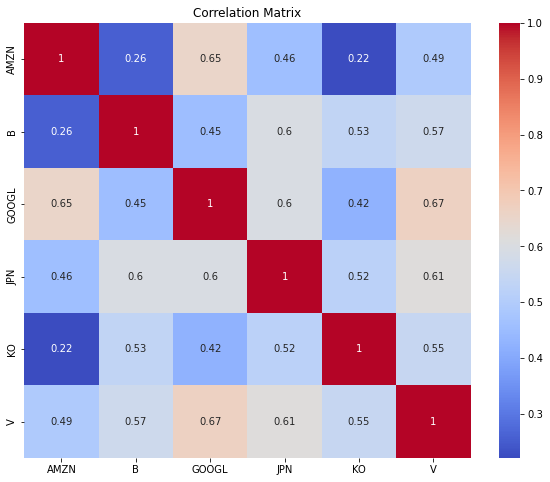

In [321]:
corr_matrix = portfolio_returns['Adj Close'].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [322]:
np.random.seed(1)
num_stocks = portfolio_data.shape[1]
# Weight each security
weights = np.random.random((num_stocks,1))
# normalize it, so that sum is one
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# We generally do log return instead of return
log_ret = np.log(portfolio_data / portfolio_data.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252 
print(f'\nExpected return of the portfolio is : {exp_ret[0]}')

# Exp Volatility (Risk)
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol[0][0]}')
# Risk-free Rate
risk_free_rate = yf.Ticker('^TNX').history(period='1d', start='2018-01-01', end=None)['Close'].mean() / 100

# Sharpe ratio
sr = (exp_ret - risk_free_rate) / exp_vol
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [2.48391806e-01 4.29048586e-01 6.81253437e-05 1.80079067e-01
 8.74125593e-02 5.49998562e-02]

Expected return of the portfolio is : 0.03764927723603185

Volatility of the portfolio: 0.2699988357085127

Sharpe ratio of the portfolio: 0.059194889791774445


# Monte Carlo Simulation

We simply randomize the weights of the securities and compare the returns to the risks. And among these weights, we will select the one that provides the highest return for a given risk. 

In [350]:
# number of simulation
n = 5000
# n = 10

port_weights = np.zeros(shape=(n,len(portfolio_data.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)


for i in range(n):
    # Weight each security
    weights = np.random.random(num_stocks)
    # normalize it, so that sum is one
    weights /= np.sum(weights)
    port_weights[i,:] = weights 
    #     print(f'Normalized Weights : {weights.flatten()}')

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    exp_ret = log_ret.mean().dot(weights)*252 
    port_return[i] = exp_ret
#     print(f'\nExpected return is : {exp_ret[0]}')

    # Exp Volatility (Risk)
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
    port_volatility[i] = exp_vol
#     print(f'\nVolatility : {exp_vol[0][0]}')

    # Sharpe ratio
    sr = (exp_ret - risk_free_rate) / exp_vol
    port_sr[i] = sr
#     print(f'\nSharpe ratio : {sr[0][0]}')

In [351]:
# Index of max Sharpe Ratio
max_sr = port_sr.max()
ind = port_sr.argmax()
# Return and Volatility at Max Sharp Ratio
max_sr_ret = port_return[ind]
max_sr_vol = port_volatility[ind]

# Index of min Volatility
min_vol = port_volatility.min()
ind_min_vol = port_volatility.argmin()
# Return and Sharp Ratio at min Volatility
min_vol_return = port_return[ind_min_vol]
min_vol_sr = (min_vol_return - risk_free_rate) / min_vol

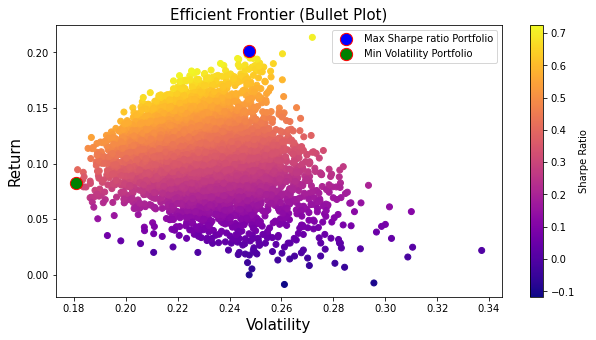

In [352]:
plt.figure(figsize=(10,5))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.scatter(min_vol, min_vol_return, c='green', s=150, edgecolors='red', marker='o', label='Min \
Volatility Portfolio')
plt.legend();

In [353]:
print("Max Sharp Ratio Portfolio :")
print("Sharp Ratio is", max_sr)
print("Return is", max_sr_ret)
print("Volatility is", max_sr_vol)

Max Sharp Ratio Portfolio :
Sharp Ratio is 0.7250880503208488
Return is 0.20109704133560385
Volatility is 0.24746003653466306


In [354]:
stocks = portfolio_data.columns
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

36.68 % of AMZN should be bought.
2.44 % of B should be bought.
37.89 % of GOOGL should be bought.
0.32 % of JPN should be bought.
13.44 % of KO should be bought.
9.22 % of V should be bought.


In [355]:
print("Min Volatility Portfolio :")
print("Sharp Ratio is", min_vol_sr)
print("Return is", min_vol_return)
print("Volatility is", min_vol)

Min Volatility Portfolio :
Sharp Ratio is 0.33483617532862575
Return is 0.08217093542341126
Volatility is 0.1806979471428684


In [356]:
stocks = portfolio_data.columns
for weight, stock in zip(port_weights[ind_min_vol],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

18.42 % of AMZN should be bought.
2.85 % of B should be bought.
7.92 % of GOOGL should be bought.
46.89 % of JPN should be bought.
21.29 % of KO should be bought.
2.62 % of V should be bought.


# Now we will find the optimal portfolio based on the risk aversion of user

# 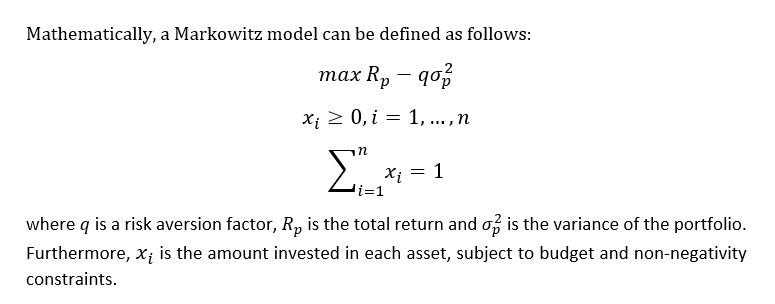

In [384]:
vol_range = input("Enter your desired volatility range in the format 'min-max': ")
min_vol, max_vol = map(float, vol_range.split('-'))
ind_user_vol = np.where((port_volatility >= min_vol) & (port_volatility <= max_vol))[0]
if len(ind_user_vol) == 0:
    print("No portfolios found within the specified volatility range.")
else:
    max_return_index = np.argmax(port_return[ind_user_vol])
    user_vol_return = port_return[ind_user_vol][max_return_index]
    user_vol = port_volatility[ind_user_vol][max_return_index]
    user_vol_sr = (user_vol_return - risk_free_rate) / user_vol

Enter your desired volatility range in the format 'min-max': 0.19-0.192


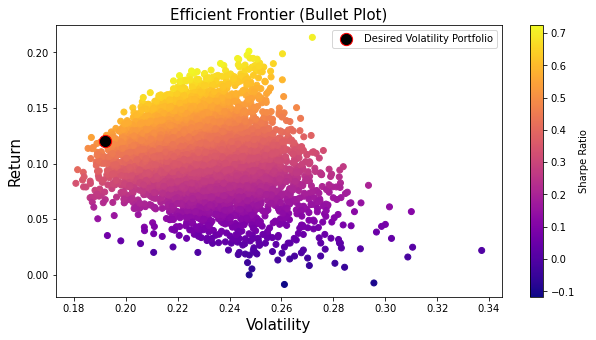

In [385]:
plt.figure(figsize=(10,5))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(user_vol, user_vol_return, c='black', s=150, edgecolors='red', marker='o', label='Desired Volatility Portfolio')
plt.legend();

In [386]:
print("Desired Volatility Portfolio :")
print("Sharp Ratio is", user_vol_sr)
print("Return is", user_vol_return)
print("Given Volatility is", user_vol)

Desired Volatility Portfolio :
Sharp Ratio is 0.5118841856813029
Return is 0.11982218693436913
Given Volatility is 0.19175325936543255


In [387]:
stocks = portfolio_data.columns
for weight, stock in zip(port_weights[ind_user_vol].flatten(), stocks):
    print(f'{round(float(weight) * 100, 2)} % of {stock} should be bought.')

12.53 % of AMZN should be bought.
0.8 % of B should be bought.
10.24 % of GOOGL should be bought.
38.34 % of JPN should be bought.
17.79 % of KO should be bought.
20.29 % of V should be bought.
